# Plant Pathology using TPU-DenseNetMoblile
I have used the prebuild model in keras - Keras Application.Keras Applications are deep learning models that are made available alongside pre-trained weights. You can read more about them [here](https://keras.io/applications/).
1. [Pre-processing Images](#head1)
2. [CNN Model](#head2)
  * [Load in pre-trained model](#head2a)
  * [Add Final trainable layers to pre-built model](#head2b)
  * [Learing Rate Scheduler](#head2c)
3. [Evaluation and training curves.](#head3)

In [1]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from kaggle_datasets import KaggleDatasets
%matplotlib inline
scale_percent = 30
# width = int(1365 * scale_percent / 100)
# height = int(2048 * scale_percent / 100)
width = 512
height = 512
dim = (width, height)
dim

(512, 512)

In [2]:
AUTO = tf.data.experimental.AUTOTUNE

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

batch_size = 16*tpu_strategy.num_replicas_in_sync

In [3]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path()
GCS_DS_PATH

'gs://kds-44c8a6f93070fa89189427ff10c4c0530ab3f532ac92907ab3c2bb58'

In [4]:
def ImageIDtodir(label):
    return GCS_DS_PATH+'/images/' + label + '.jpg'
train_df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/train.csv')
train_dir = train_df['image_id'].apply(ImageIDtodir).values
test_df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
test_dir = test_df['image_id'].apply(ImageIDtodir).values
y =  train_df.loc[:, 'healthy':].values
train_dir, valid_dir, y_train, y_val = train_test_split(train_dir,y,test_size=0.15)

# <a name="head1"></a>1.Pre-processing Images 
we are using tensorflow tensor_from_slices to read images while training directly from the file.Images are reshaped to 512x512x3.
I am also splitting the train images into training and validation with a validation split of 0.15.   
The train images are flipped randomly but no such pre-processing is done on validation or train images.

In [5]:
def load_image(filename, label=None,image_size=(width,height)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image,image_size)   
    if label is None:
        return image
    else:
        return image, label
    

def augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if label is None:
        return image
    else:
        return image, label

In [6]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_dir, y_train))
    .map(load_image, num_parallel_calls=AUTO)
    .cache()
    .map(augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(batch_size)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset.from_tensor_slices((valid_dir,y_val))
    .map(load_image, num_parallel_calls=AUTO)
    .cache()
    .batch(batch_size)
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_dir)
    .map(load_image, num_parallel_calls=AUTO)
    .cache()
    .batch(batch_size)
)

# <a name="head2"></a>2. CNN Model

## A. <a name="head2a"></a>Load in Pre-trained model.
I have used the DenseNetMobile in-built model with pre-trained weights. You can read about other Keras Applications [here](https://keras.io/applications/#available-models).   

## B. <a name="head2b"></a>Add Final trainable Layers to pre-built model.
As we need to categories the images into 4 labels we need to add another layer to the model.     
The ouput of the DenseNet model which are essentially features extracted from the images are passed on to more layers-
* A Global average pooling layer
* A Dropout layer with rate 0.3
* A Dense layer with 50 units and relu activation.
* A Dense layer with 4 units and softmax activation.  
   
The last layer is which gives out the precitions.   
  

In [7]:
with tpu_strategy.scope():
    DenseNetModel = tf.keras.applications.DenseNet121(input_shape=(width,height,3),
                                              weights='imagenet',
                                              include_top=False)
    model = tf.keras.models.Sequential(
        [DenseNetModel,
#             tf.keras.layers.Convolution2D(1024,(5,5),strides=(2,2),activation='relu'),
#             tf.keras.layers.Convolution2D(2048,(4,4),strides=(2,2),activation='relu'),
#             tf.keras.layers.AveragePooling2D((5,5),2),
#             tf.keras.layers.AveragePooling2D((4,4),2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')]
    )
    # Compile the model
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])

29089792/29084464 [==============================] - 1s 0us/step


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 16, 16, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                51250     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 7,088,958
Trainable params: 7,005,310
Non-trainable params: 83,648
_________________________________________________________________


# <a name="head2b"></a> Learing Rate Scheduler
We have to reduce our learning mid-training as the 

In [9]:
# Learning rate schedular
def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 5
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
]

In [10]:
history = model.fit(train_dataset,
                    epochs=25,
                    callbacks=callbacks,
                    steps_per_epoch=y.shape[0] // batch_size,
                    validation_data=valid_dataset)

Train for 14 steps, validate for 3 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/25
14/14 [==============================] - 219s 16s/step - loss: 0.6901 - accuracy: 0.7690 - auc: 0.9274 - val_loss: 24.4483 - val_accuracy: 0.3577 - val_auc: 0.5718

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/25
14/14 [==============================] - 6s 418ms/step - loss: 0.3212 - accuracy: 0.9029 - auc: 0.9799 - val_loss: 47.2992 - val_accuracy: 0.3577 - val_auc: 0.5718

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/25
14/14 [==============================] - 6s 408ms/step - loss: 0.2194 - accuracy: 0.9330 - auc: 0.9891 - val_loss: 14.1203 - val_accuracy: 0.3577 - val_auc: 0.5735

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/25
14/14 [==============================] - 6s 406ms/step - loss: 0.2048 - accuracy: 0

# <a name="head3"></a>3. Evaluation and training Curves

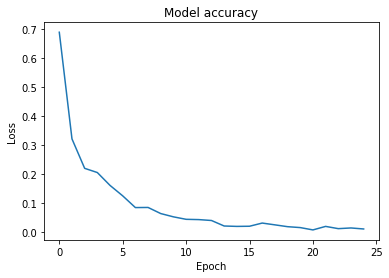

In [11]:
plt.plot(history.history['loss'])
plt.title('Model accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [12]:
predictions = model.predict(test_dataset,verbose=1)

15/15 [==============================] - 118s 8s/step


In [13]:
temp_df = pd.read_csv('/kaggle/input/plant-pathology-2020-fgvc7/test.csv')
submission = pd.DataFrame(
    {'image_id': temp_df['image_id'],
     'healthy': predictions[:,0],
     'multiple_diseases': predictions[:,1],
     'rust': predictions[:,2],
     'scab': predictions[:,3],
    })
submission.to_csv("plant_pathology.csv",index=False)
submission

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,1.199259e-03,0.009532,9.891158e-01,1.526450e-04
1,Test_1,1.022515e-04,0.000813,9.990321e-01,5.232752e-05
2,Test_2,8.236055e-05,0.000022,1.121791e-05,9.998840e-01
3,Test_3,9.999143e-01,0.000006,8.458936e-06,7.151408e-05
4,Test_4,3.958382e-06,0.000149,9.998214e-01,2.583578e-05
...,...,...,...,...,...
1816,Test_1816,5.730747e-08,0.000006,9.999930e-01,7.927180e-07
1817,Test_1817,3.252980e-02,0.006161,3.782881e-03,9.575266e-01
1818,Test_1818,9.203129e-07,0.000014,9.999844e-01,7.476804e-07
1819,Test_1819,9.999589e-01,0.000002,5.900764e-07,3.815549e-05
